## Not really an intro from me...

I choose house prices as my first kernel on Kaggle because I hope to go over the entire analytic process in this kernel. We all know that data cleaning is the dirtist part of a whole project but it is also the foundation for further study. So you can see that the data cleaning part occupies most of the space. There are far more techniques that can be incorporated and more precise analyses can be done. I just point out the basic steps I think are most important. Now let us start!

Roadmap:
1. Import data
1. Preliminary analysis
    * For numerical variables: descriptive stats, distribution and normality test, correlation analysis
    * For categorical variables: frequency table, correlation analysis 
1. Data preparation
    * Missing data imputation
    * For numerical variables: standardization or Yeo-Johnson transformation
    * For categorical varaibles: one-hot encoding
    * Principal component analysis
1. Modeling
    * Random Forests
    * XGBoost
    * Neural Networks

## Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
train.shape

(1460, 81)

In [3]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
test.shape

(1459, 80)

## Preliminary Analysis

### Numeric Variables

I split the analysis based on the different types of variables. It is easier to describe the numeric variables since we can calculate descriptive statistics and apply various statistical tests.

In [5]:
train_num = train.select_dtypes(exclude=['object']).columns
train_num

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### 1. Basic statistics

In [6]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


The first line "count" indicates several variables that have missing values given the total number of observations is 1460, - LotFrontage, MasVnrArea, GarageYrBlt. LotFrontage's missing values are the most, which is 259. Judged from mean, quantiles, etc., we can also identify many skewed variables, for example, BsmtFinSF1 (Type 1 finished square feet), BsmtFullBath (Basement full bathrooms), LotArea (Lot size in square feet), MasVnrArea (Masonry veneer area in square feet).

#### 2. Check the distribution

The basic idea is to observe the distribution of variables in plots. I also apply shapiro wilk normality test here for reference. But one thing I find about shapiro test is that it is not so reliable when the data is large. It can be easily influenced by even small deviations and since its null hypothesis is normality assumption, it tends to reject the null in fact. Check more explanations here: https://stats.stackexchange.com/questions/2492/is-normality-testing-essentially-useless?noredirect=1&lq=1.

Skewness=1.686
Statistics=0.848, p=0.000
Data does not look normal (reject H0)


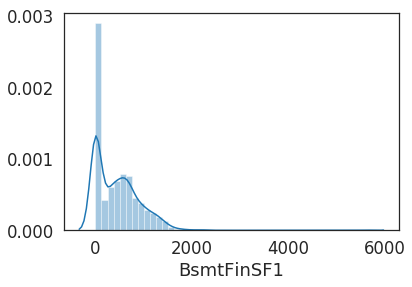

In [7]:
from scipy.stats import shapiro
# apply shapiro test
stat, p = shapiro(train['BsmtFinSF1'])
print('Skewness=%.3f' %train['BsmtFinSF1'].skew())
print('Statistics=%.3f, p=%.3f' %(stat, p))

# set alpha to 0.05: when p > 0.05, accept the null hypothesis; when p < 0.05, reject the null
alpha = 0.05
if p > alpha:
    print('Data looks normal (fail to reject H0)')
else:
    print('Data does not look normal (reject H0)')

sns.distplot(train['BsmtFinSF1']);

**BsmtFinSF1** is highly skewed and its distribution is not normal based on the Shapiro-Wilk test.

Skewness=0.596
Statistics=0.658, p=0.000


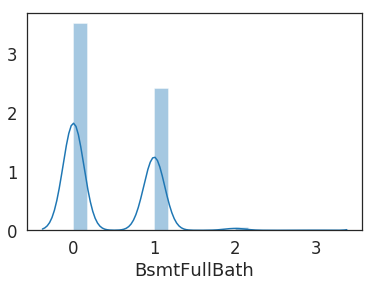

In [8]:
stat, p = shapiro(train['BsmtFullBath'])
print('Skewness=%.3f' %train['BsmtFullBath'].skew())
print('Statistics=%.3f, p=%.3f' %(stat, p))

sns.distplot(train['BsmtFullBath']);

**BsmtFullBath** is moderately skewed but its distribution is not normal either because p value is smaller than 0.05. Acutally we can observe its distribution in the plot which has two peaks.

Skewness=12.208
Statistics=0.351, p=0.000


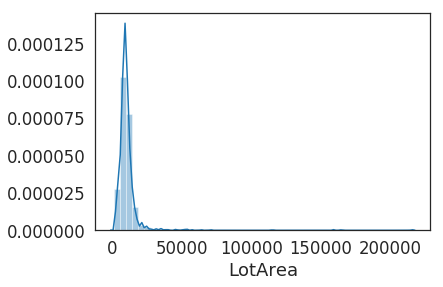

In [9]:
stat, p = shapiro(train['LotArea'])
print('Skewness=%.3f' %train['LotArea'].skew())
print('Statistics=%.3f, p=%.3f' %(stat, p))

sns.distplot(train['LotArea']);

Another highly skewed variables **LotArea** has a long left tail. The majority of values are around 10,000 but it maximum value can reach to over 200,000.

After log transformation...
Skewness=-0.138
Statistics=0.905, p=0.000


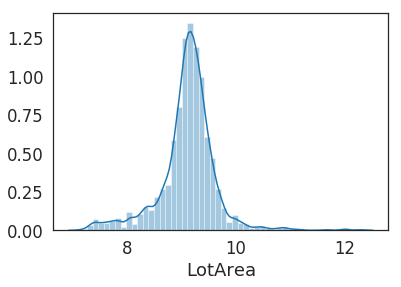

In [10]:
stat, p = shapiro(np.log(train['LotArea']))
print('After log transformation...')
print('Skewness=%.3f' %np.log(train['LotArea']).skew())
print('Statistics=%.3f, p=%.3f' %(stat, p))

sns.distplot(np.log(train['LotArea']));

After we apply the log transformation to LotArea, the skewness is reduced a lot but it is still not a normal distribution based on the test.

Skewness=2.669
Statistics=0.639, p=0.000


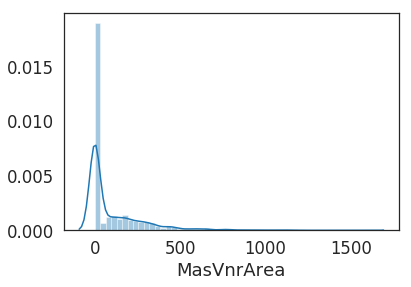

In [11]:
stat, p = shapiro(train['MasVnrArea'].dropna())
print('Skewness=%.3f' %train['MasVnrArea'].skew())
print('Statistics=%.3f, p=%.3f' %(stat, p))

sns.distplot(train['MasVnrArea'].dropna());

Skewness=2.669
Statistics=0.639, p=0.000


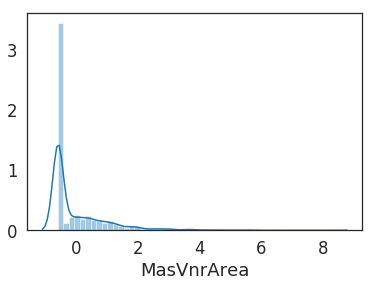

In [12]:
masvnrarea_std = (train['MasVnrArea'] - np.mean(train['MasVnrArea'])) / np.std(train['MasVnrArea'])
stat, p = shapiro(masvnrarea_std.dropna())
print('Skewness=%.3f' %masvnrarea_std.skew())
print('Statistics=%.3f, p=%.3f' %(stat, p))

sns.distplot(masvnrarea_std.dropna());

Try the standardization with **MasVnrArea**, but it does not change anything. 

**Now let us take a look at our response variable: SalePrice**

Skewness=1.883
Statistics=0.870, p=0.000


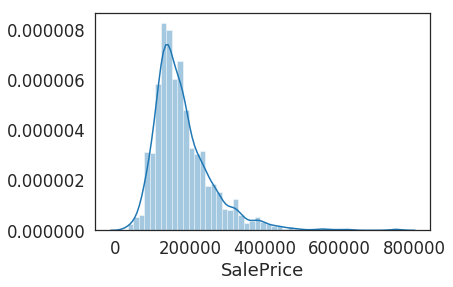

In [13]:
stat, p = shapiro(train['SalePrice'])
print('Skewness=%.3f' %train['SalePrice'].skew())
print('Statistics=%.3f, p=%.3f' %(stat, p))

sns.distplot(train['SalePrice']);

After log transformation...
Skewness=0.121
Statistics=0.991, p=0.000


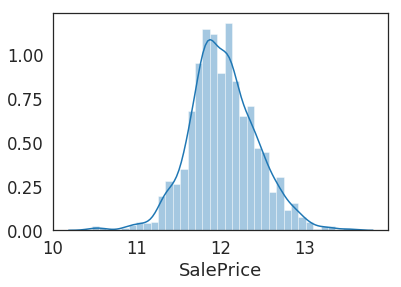

In [14]:
stat, p = shapiro(np.log(train['SalePrice']))
print('After log transformation...')
print('Skewness=%.3f' %np.log(train['SalePrice']).skew())
print('Statistics=%.3f, p=%.3f' %(stat, p))

sns.distplot(np.log(train['SalePrice']));

Before log transformation, SalePrice is highly skewed. While log transformation can help with reducing skewness, it can not transform the data to normal distribution (perhaps). But at least from the plot, we can see that it is improved a lot compared to before. So I will still go with the log transformation.

#### 3. Correlation analysis

In [15]:
train_num_corr = train[train_num].drop(['Id'], axis=1)
corr = pd.DataFrame(train_num_corr.corr(method = 'pearson')['SalePrice'])
corr.sort_values(['SalePrice'], ascending= False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


OverallQual (Overall material and finish quality), GrLivArea (Above grade (ground) living area square feet), GarageCars (Size of garage in car capacity), GarageArea (Size of garage in square feet), TotalBsmtSF (Total square feet of basement area), 1stFlrSF (First Floor square feet), etc. are highly correlated with our response variable, SalePrice. We can then conclude that area-related variables (including ground living area, garage area, basement area, number of rooms) as well as quality and year (like construction year, remodeled year) are the major continous factors associated with the sale price of a house.

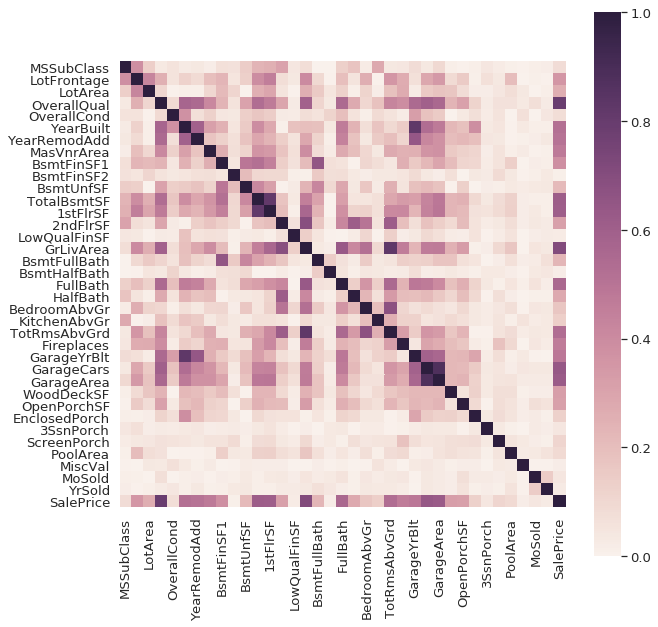

In [16]:
cmap = sns.cubehelix_palette(light = 0.95, as_cmap = True)
sns.set(font_scale=1.2)
plt.figure(figsize = (10, 10))
sns.heatmap(abs(train_num_corr.corr(method = 'pearson')), vmin = 0, vmax = 1, square = True, cmap = cmap);

From the last row of the heatmap, we can get the same information as from the previous correlation table. Other than this, we can also find the multicollinearity problems with the data, for example, GarageCars and GarageArea, YearBuilt and GarageYrBlt.

### Categorical Variables

#### 1. Check the distribution

For categorical variables, I make a frequency table to show the distribution.

In [17]:
train_cat = train.select_dtypes(include=['object']).columns
train_cat

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [18]:
pd.set_option('display.max_rows', 300)
df_output = pd.DataFrame()
# loop through categorical variables, and append calculated stats together
for i in range(len(train_cat)):
    c = train_cat[i]
    df = pd.DataFrame({'Variable':[c]*len(train[c].unique()),
                       'Level':train[c].unique(),
                       'Count':train[c].value_counts(dropna = False)})
    df['Percentage'] = 100 * df['Count']  / df['Count'].sum()
    df_output = df_output.append(df, ignore_index = True)
    
df_output

,Variable,Level,Count,Percentage
0,MSZoning,RL,1151,78.835616
1,MSZoning,RM,218,14.931507
2,MSZoning,C (all),65,4.452055
3,MSZoning,FV,16,1.095890
4,MSZoning,RH,10,0.684932
5,Street,Pave,1454,99.589041
6,Street,Grvl,6,0.410959
7,Alley,NaN,1369,93.767123
8,Alley,Grvl,50,3.424658
9,Alley,Pave,41,2.808219


Judged from the frequency table, we can infer that the majority of categorical variables are unbalanced. Several classes even only have 1 or 2 observations. Worsely, Alley, FireplaceQu, PoolQC, Fence, MiscFeature contain missing values over 50%.

#### 2. Correlation with SalePrice

Take several variables for example:

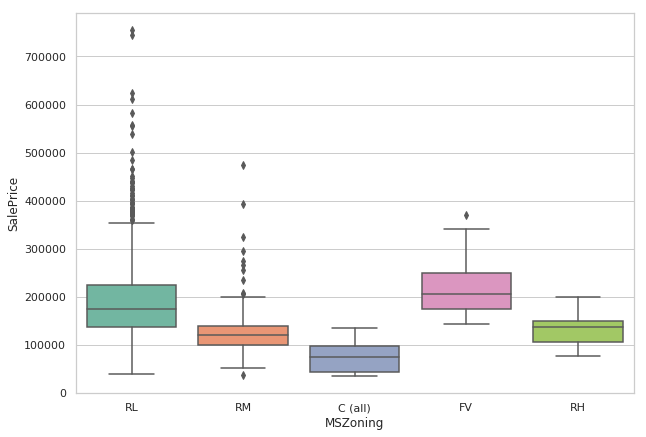

In [19]:
sns.set(style = 'whitegrid', rc = {'figure.figsize':(10,7), 'axes.labelsize':12})
sns.boxplot(x = 'MSZoning', y = 'SalePrice', palette = 'Set2', data = train, linewidth = 1.5);

**MSZoning**. Most of houses are in the Residential Low Density (79%) and Residential Medium Density (15%) areas. However, there is a large variance within the Residential Low (RL) zone. Floating Village(FV) is a special area where a retirement community was developed and have the highest median price among the all. But there are only 16 observations falling within this category and their prices do not seem quite stable looking at the shape of the box of FV.

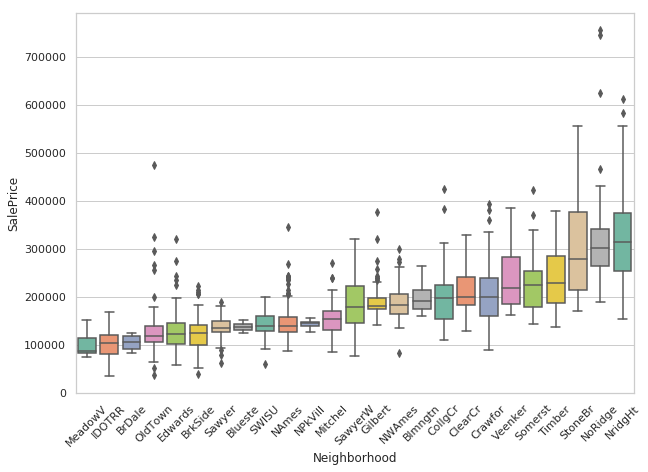

In [20]:
col_order = train.groupby(['Neighborhood'])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
p = sns.boxplot(x = 'Neighborhood', y = 'SalePrice', palette = 'Set2', data = train, order=col_order['Neighborhood'], linewidth = 1.5)
plt.setp(p.get_xticklabels(), rotation=45);

**Neighborhood**. Besides the zoning classfication, neighborhood also makes a difference. Houses located at Northridge Heights (NridgHt) have higher sale prices than those in other areas generally but the variance is large. The difference between median price of MeadowV (neighborhood with the lowest house prices) and that of NridgHt is over $200,000.

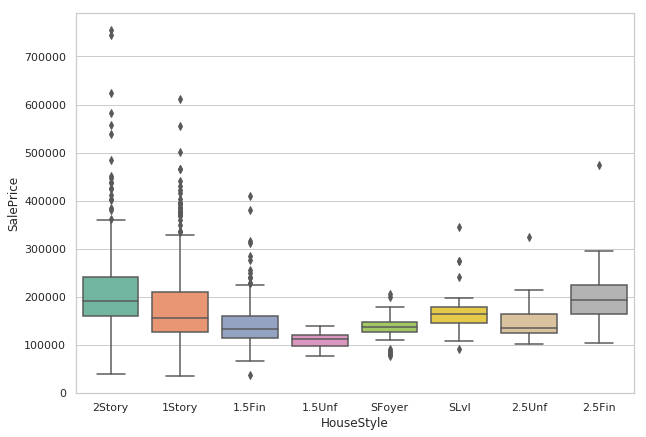

In [21]:
sns.boxplot(x = 'HouseStyle', y = 'SalePrice', palette = 'Set2', data = train, linewidth = 1.5);

**HouseStyle**. Locations matter a lot when considering house prices, then what about the characteristics of house itself? Popular house styles are 2 Story (50%) and 1 Story (30%). 2 story and 2.5 story (2nd level finished) houses can be sold at relatively higher prices, around 200,000 dollars, while the prices of 1.5 story (2nd level unfinished) houses are mostly around 110,000 dollars. Notably, for multiple story houses, 2 level finished or unfinished have an obvious relationship with house prices.

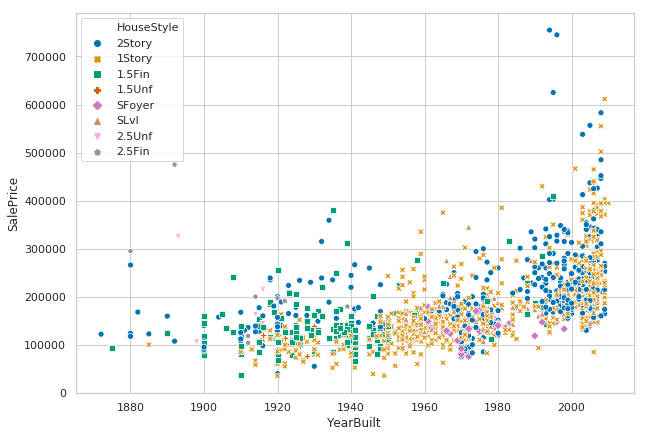

In [22]:
sns.scatterplot(x = 'YearBuilt', y = 'SalePrice', data = train, hue = 'HouseStyle', style = 'HouseStyle', palette = 'colorblind');

After introducing year of built into our plot, we can see that houses built in recent years tend to have higher sale prices, especially since 1960. YearBuilt also has certain association with HouseStyle. We can identify at least three clusters in this plot, blue points (2Story) mostly near the right, yellow (1Story) most in the between, and green (1.5Fin) on the left. 

Intuitively, we assume that the price of house with more stories is higher. For example, when there are 2 story houses built in like 1930, they were sold usually at higher prices than green (1.5Fin) and yellow (1Story) points. But from the box plot we already see that 1.5Fin is less expensive than 1Story. This may be explained by YearBuilt since majority of green 1.5Fin were built between 1900 and 1940 while yellow 1Story between 1940 and 1980 and many were built after 2000.

## Data Preparation

### ** Impute Missing Values **

#### 1. Drop columns where there is a large percentage of missing data

In [23]:
print(train.isnull().sum())

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

How to define "a large percentage"? Let us try 15% first.

In [24]:
# training data
# calculate percentage of missing values
train_missing = pd.DataFrame(train.isnull().sum()/len(train.index) * 100)
train_missing.columns = ['percent']

# flag columns whose missing percentage are larger than 15%
train_missing.loc[train_missing['percent'] > 15, 'column_select'] = True
train_col_select = train_missing.index[train_missing['column_select'] == True].tolist()
train_col_select

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [25]:
# test data
test_missing = pd.DataFrame(test.isnull().sum()/len(test.index) * 100)
test_missing.columns = ['percent']
test_missing.loc[test_missing['percent'] > 15, 'column_select'] = True
test_col_select = test_missing.index[test_missing['column_select'] == True].tolist()
test_col_select

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

We know that Alley, FireplaceQu, PoolQC, Fence, MiscFeature are all categorical variables and their missing values occupy over 50% of total. They should be dropped. But LogFrontage has 1201 rows which I personally decide to keep.

In [26]:
# drop LotFrontage
train_col_select.pop(0)
test_col_select.pop(0)

'LotFrontage'

In [27]:
train.drop(train_col_select, inplace = True, axis = 1, errors = 'ignore')
test.drop(test_col_select, inplace = True, axis = 1, errors = 'ignore')

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


Note that we orginally have 81 variables for training set and 80 for test set.

In [28]:
train.shape

(1460, 76)

In [29]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,0,1,2010,WD,Normal


In [30]:
test.shape

(1459, 75)

#### 2. Use medians for numeric variables and the most frequent values for non-numeric variables to replace NA

TansformerMixin can be used to define a custom transformer dealing with heterogeneous data types, which basically contains two major parts:
- fit: Uses the input data to train the transformer
- transform: Takes the input features and transforms them

In [31]:
from sklearn.base import TransformerMixin
class MissingDataImputer(TransformerMixin):
    def fit(self, X, y=None):
        """Extract mode for categorical features and median for numeric features"""        
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self

    def transform(self, X, y=None):
        """Replace missingness with the array got from fit"""
        return X.fillna(self.fill)

In [32]:
train_nmissing = MissingDataImputer().fit_transform(train.iloc[:,1:-1])
test_nmissing = MissingDataImputer().fit_transform(test.iloc[:,1:])
train_nmissing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal


In [33]:
print(train_nmissing.isnull().sum())

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd

### **Transform the Data**

#### 1. For categorical variables, apply onehot encoding

1)  Check if training data and test data have the same categorical variables

In [34]:
train_cat = train_nmissing.select_dtypes(include=['object']).columns
test_cat = test_nmissing.select_dtypes(include=['object']).columns
train_cat.difference(test_cat)

Index([], dtype='object')

2) Create dummy variables

I am not using LabelEncoder here because for most categorical variables their values are not in order. I use one hot encoding instead. To ensure that the output matrices are in the same order as in training and test data, I decide to create the one-hot arrays with get_dummies instead of sklearn OneHotEncoder.

In [35]:
train_w_dummy = pd.get_dummies(train_nmissing, prefix_sep='_', drop_first=True, columns=train_cat)
test_w_dummy = pd.get_dummies(test_nmissing, prefix_sep='_', drop_first=True, columns=test_cat)

# find all dummy variables in the training set
cat_dummies = [col for col in train_w_dummy 
               if '_' in col 
               and col.split('_')[0] in train_cat]

3)  Remove additional variales and add missing variables in test data

In [36]:
# drop dummy variables in test set but not in training set
for col in test_w_dummy.columns:
    if ("_" in col) and (col.split("_")[0] in train_cat) and col not in cat_dummies:
        test_w_dummy.drop(col, axis=1, inplace=True)

# add dummy variables in training set but not in test set, and assign them 0
for col in cat_dummies:
    if col not in test_w_dummy.columns:
        test_w_dummy[col] = 0        

4) Make sure that variables in test data have the same order as in training data

In [37]:
train_cols = list(train_w_dummy.columns[:])
test_w_dummy = test_w_dummy[train_cols]

Remember that we have 76 variables for training and 75 for test before...

In [38]:
train_w_dummy.shape

(1460, 232)

In [39]:
test_w_dummy.shape

(1459, 232)

#### 2. For numeric variables, normalize the data

1) Check if training data and test data have the same numeric variables

In [40]:
train_num = train_nmissing.select_dtypes(exclude=['object']).columns
test_num = test_nmissing.select_dtypes(exclude=['object']).columns
test_num.difference(train_num)

Index([], dtype='object')

2) Normalize test data: standardization or Yeo-Johnson transformation

As we have experimented before, standardization does not change the shape of the distribution in nature but log transformation does. Log transformation requires data to be positive while Yeo-Johnson transformation supports both positive or negative data. 

I simply choose skewness as the criterion to select between standardization and Yeo-Johnson transformation because I am not training my data on linear regression models. There are of course more rigorous criteria.

In [41]:
train_num_std = [col for col in train_num if abs(train_w_dummy[col].skew()) <= 1]
train_num_yjt = [col for col in train_num if abs(train_w_dummy[col].skew()) > 1]

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

# standardization
scaler = StandardScaler().fit(train_w_dummy[train_num_std].values)
train_w_dummy[train_num_std] = scaler.transform(train_w_dummy[train_num_std].values)
test_w_dummy[train_num_std] = scaler.transform(test_w_dummy[train_num_std].values)

# power transform
pt = PowerTransformer().fit(train_w_dummy[train_num_yjt].values)
train_w_dummy[train_num_yjt] = pt.transform(train_w_dummy[train_num_yjt].values)
test_w_dummy[train_num_yjt] = pt.transform(test_w_dummy[train_num_yjt].values)

In [43]:
test_w_dummy.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,...,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-1.164269,0.546852,0.477105,-0.795151,0.381743,-0.340077,-1.156380,-0.818452,0.549525,2.782196,-0.672923,-0.342653,-0.653100,-0.795163,-0.134652,-1.408075,-0.819964,-0.24394,-1.026041,-0.761621,-1.062465,-0.172658,-0.934130,-0.951226,-0.733219,-1.026858,1.202536,0.980706,-1.071307,-0.407595,-0.129279,3.403844,-0.069409,-0.192177,-0.119110,1.64521,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,-1.164269,0.590269,0.878090,-0.071836,0.381743,-0.439440,-1.301740,1.109742,0.972297,-0.359384,-0.365032,0.650737,0.590073,-0.795163,-0.134652,-0.227707,-0.819964,-0.24394,-1.026041,1.227585,0.163779,-0.172658,-0.318683,-0.951226,-0.858277,-1.026858,-0.753188,1.295845,0.597468,-0.407595,-0.129279,-0.293785,-0.069409,5.203549,-0.119110,1.64521,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0.493460,0.279518,0.817091,-0.795151,-0.517200,0.852269,0.636400,-0.818452,0.870352,-0.359384,-0.974021,-0.235202,-0.540872,0.811239,-0.134652,0.382851,-0.819964,-0.24394,0.789741,1.227585,0.163779,-0.172658,-0.318683,0.600495,0.767481,0.311725,0.042202,1.110286,0.571252,-0.407595,-0.129279,-0.293785,-0.069409,-0.192177,-1.229111,1.64521,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0.493460,0.459068,0.180493,-0.071836,0.381743,0.885390,0.636400,0.664700,0.698615,-0.359384,-0.550672,-0.239844,-0.547763,0.758532,-0.134652,0.336431,-0.819964,-0.24394,0.789741,1.227585,0.163779,-0.172658,0.296763,0.600495,0.809167,0.311725,-0.013943,1.269999,0.597468,-0.407595,-0.129279,-0.293785,-0.069409,-0.192177,-0.119110,1.64521,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,1.363243,-1.355641,-1.143948,1.374795,-0.517200,0.686666,0.345679,-0.818452,0.239162,-0.359384,1.018211,0.546666,0.473274,-0.795163,-0.134652,-0.340311,-0.819964,-0.24394,0.789741,-0.761621,-1.062465,-0.172658,-0.934130,-0.951226,0.559051,0.311725,0.154492,-0.950337,0.980550,-0.407595,-0.129279,3.403856,-0.069409,-0.192177,-1.969111,1.64521,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


3. Apply Principal Component Analysis

To address the multicolliearity problem, I apply PCA to decrease the number of variables.

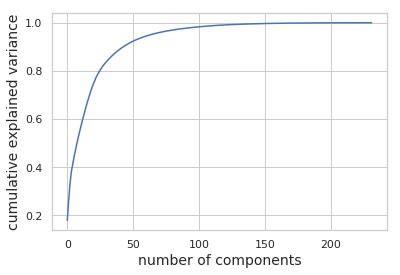

In [44]:
from sklearn.decomposition import PCA
pca = PCA().fit(train_w_dummy)
plt.figure(figsize = (6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components', fontsize = 14)
plt.ylabel('cumulative explained variance', fontsize = 14)

plt.grid(True);

It is clear to notice that the first 100 variables contain nearly 100% of the variance.

In [45]:
pca = PCA(n_components = 100)
x_train = pca.fit_transform(train_w_dummy) 
x_test = pca.transform(test_w_dummy) 

## **Start Training**

I am not going to use regression models for now because of the assumptions they make on the data. And my transformation is just to speed up convergence during training. Instead, I will try with random forests, boosting, and neural networks.

In [46]:
# do not forget to log transform our response variable
y_train = train['SalePrice'].values
y_train_log = np.log1p(train['SalePrice']).values

y_test_data = pd.read_csv('../input/sample_submission.csv')
y_test = y_test_data['SalePrice'].values
y_test_log = np.log1p(y_test_data['SalePrice']).values

#### 1. Random Forest


In [47]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
rf_base = RandomForestRegressor(n_estimators=400)

# look at parameters used by our base forest
pprint(rf_base.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


I will start from the original y_train to train the random forest and then use the log transformed y_train to train.

In [48]:
# base model result
from sklearn import metrics

# model with original y_train
rf_base.fit(x_train, y_train)
y_pred_rf_base = rf_base.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf_base))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf_base))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_base)))

Mean Absolute Error: 53546.03002145024
Mean Squared Error: 4816935898.255097
Root Mean Squared Error: 69404.1489988538


In [49]:
rf_base.score(x_train, y_train)

0.9777353023299813

In [50]:
# model with log transformed y_train
rf_base.fit(x_train, y_train_log)
# need to take exponential before calculating mse, etc. in order to compare
y_pred_rf_base_log = np.exp(rf_base.predict(x_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf_base_log))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf_base_log))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_base_log)))

Mean Absolute Error: 53258.70851154663
Mean Squared Error: 4621074429.930577
Root Mean Squared Error: 67978.4850517469


In [51]:
rf_base.score(x_train, y_train_log)

0.9820802388306713

Comparing the metrics, Log transformation is helpful in the random forest case. Both of the R squared are high though. So we ill go with the log transformed y_train.

**Hyperparameter tuning**

1) Randomized search

Compared to grid search, randomized search is less time-consuming so we start from a wider range of parameters with randomized search. In this case, 100 sets of parameters are sampled from all combinations to train.

In [52]:
from sklearn.model_selection import RandomizedSearchCV

# params that will be sampled from
max_depth = [int(x) for x in np.linspace(40, 80, num = 5)]
max_depth.append(None)
random_params = {'n_estimators': [200, 400, 600, 800, 1000, 1200],
                'max_depth': max_depth,
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2, 4]}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_params, n_iter = 100, cv = 3, n_jobs = -1, verbose = 2, random_state = 1)
rf_random.fit(x_train, y_train_log)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 59.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 105.7min finished


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': None}

In [53]:
rf_random.best_score_

0.8605219940516167

In [54]:
# random search with best performance parameters
rf_random_best = rf_random.best_estimator_
y_pred_rf_random = np.exp(rf_random_best.predict(x_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf_random))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf_random))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_random)))

Mean Absolute Error: 53384.91475300341
Mean Squared Error: 4658444040.179569
Root Mean Squared Error: 68252.79510891528


The random search model does not yield a better model. Judging from the errors, the differences are quite small. But remember these are log transformed results. To save time, I do not include more parameter settings but it definity worths a try.

2) Grid search

Basically, grid search considers all the combinations of parameters so it takes longer time than randomized search. I would use more refined tuning through grid search.

In [55]:
from sklearn.model_selection import GridSearchCV
grid_params = {'max_depth': [45, 50, 55, None],
               'min_samples_leaf': [1, 2],
               'min_samples_split': [2, 4, 5],
               'n_estimators': [800, 900, 1000]}

rf_grid = GridSearchCV(estimator = rf, param_grid = grid_params, cv = 3, n_jobs = -1, verbose = 2)
rf_grid.fit(x_train, y_train_log)
rf_grid.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 70.4min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 95.0min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=55,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [56]:
rf_grid.best_score_

0.860316894852404

In [57]:
# grid search with best performance parameters
rf_grid_best = rf_grid.best_estimator_
y_pred_rf_grd = np.exp(rf_grid_best.predict(x_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf_grd))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf_grd))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_grd)))

Mean Absolute Error: 53256.93097608438
Mean Squared Error: 4617672894.581388
Root Mean Squared Error: 67953.46124062694


Compared to random search model, grid search model performs a little better. 

In [58]:
#prediction = pd.DataFrame(np.exp(y_pred_rf_base), columns = ['SalePrice'])
#result = pd.concat([y_test_data['Id'], prediction], axis = 1)
#result.to_csv('./Predictions.csv', index=False)

#### 2. XGBoost

In [59]:
from xgboost import XGBRegressor
xgb_base = XGBRegressor()

# current parameters used by XGBoost
pprint(xgb_base.get_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}


Same with random forest, I will compare the results between model with original y_train and model with log transformed y_train.

In [60]:
# model with original y_train
xgb_base.fit(x_train, y_train)
y_pred_xgb_base = xgb_base.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_xgb_base))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_xgb_base))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb_base)))

Mean Absolute Error: 53920.88579749481
Mean Squared Error: 5244678697.129522
Root Mean Squared Error: 72420.15394301177


In [61]:
xgb_base.score(x_train, y_train)

0.9681762642929775

In [62]:
# model with log transformed y_train
xgb_base.fit(x_train, y_train_log)
y_pred_xgb_base_log = np.exp(xgb_base.predict(x_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_xgb_base_log))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_xgb_base_log))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb_base_log)))

Mean Absolute Error: 53015.760814986126
Mean Squared Error: 4783497907.219608
Root Mean Squared Error: 69162.83617102185


In [63]:
xgb_base.score(x_train, y_train_log)

0.957910987731631

Noticeably, MSE and RMSE of model with y_train_log are much lower than those of model with original y_train; however, R^2 score of model with y_train_log is also a little lower. 

R^2 score is useful when we are trying to use independent variables to explain the variances in the dependent variable. But here we care MSE more since we are trying to capture the values of house prices. So in the XGBoost case, log tansformation works as well.

1) Randomized Search

In [64]:
random_params = {'learning_rate': [0.01],
                 'n_estimators': [400, 800, 1000, 1200],
                 'max_depth': [3, 5, 8],
                 'min_child_weight': [4, 6, 8],
                 'subsample': [0.8],
                 'colsample_bytree': [0.8],
                 'reg_alpha': [0, 0.005, 0.01],
                 'seed': [12]}

xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = random_params, n_iter = 100, cv = 3, n_jobs = -1, verbose = 2, random_state = 12)
xgb_random.fit(x_train, y_train_log)
xgb_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 23.4min finished


{'subsample': 0.8,
 'seed': 12,
 'reg_alpha': 0.005,
 'n_estimators': 1200,
 'min_child_weight': 8,
 'max_depth': 5,
 'learning_rate': 0.01,
 'colsample_bytree': 0.8}

In [65]:
xgb_random.best_score_

0.8891748784596284

In [66]:
xgb_random_best = xgb_random.best_estimator_
y_pred_xgb_random = np.exp(xgb_random_best.predict(x_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_xgb_random))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_xgb_random))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb_random)))

Mean Absolute Error: 53655.506537863024
Mean Squared Error: 4875850597.677043
Root Mean Squared Error: 69827.29120964842


2) Grid Search

In [67]:
grid_params = {'learning_rate': [0.01],
               'n_estimators': [400, 800, 1000, 1200],
               'max_depth': [3, 5, 8],
               'min_child_weight': [4, 6, 8],
               'subsample': [0.8],
               'colsample_bytree': [0.8],
               'reg_alpha': [0, 0.005, 0.01],
               'seed': [12]}

xgb_grid = GridSearchCV(estimator = xgb_base, param_grid = grid_params, cv = 3, n_jobs = -1, verbose = 2)
xgb_grid.fit(x_train, y_train_log)
xgb_grid.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 24.3min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=8, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=12,
       silent=True, subsample=0.8)

In [68]:
xgb_grid.best_score_

0.8891748784596284

In [69]:
# grid search with best performance parameters
xgb_grid_best = xgb_grid.best_estimator_
y_pred_xgb_grd = np.exp(xgb_grid_best.predict(x_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_xgb_grd))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_xgb_grd))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb_grd)))

Mean Absolute Error: 53655.506537863024
Mean Squared Error: 4875850597.677043
Root Mean Squared Error: 69827.29120964842


#### 3. Neural Networks

I build a neural network model in TensorFlow with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, neural_net_model.

In [70]:
import tensorflow as tf

input_dim = x_train.shape[1]
learning_rate = 0.002
n_nodes_l1 = 25
n_nodes_l2 = 25

x = tf.placeholder("float")
y = tf.placeholder("float")

def neural_net_model(data, input_dim):
    # 2 hidden layer feed forward neural net
    layer_1 = {'weights':tf.Variable(tf.random_normal([input_dim, n_nodes_l1])),
               'biases':tf.Variable(tf.random_normal([n_nodes_l1]))}

    layer_2 = {'weights':tf.Variable(tf.random_normal([n_nodes_l1, n_nodes_l2])),
               'biases':tf.Variable(tf.random_normal([n_nodes_l2]))}
    
    output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_l2, 1])),
                    'biases':tf.Variable(tf.random_normal([1]))}
    # affine function
    l1 = tf.add(tf.matmul(tf.cast(data, tf.float32), layer_1['weights']), layer_1['biases'])
    # relu activation
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1, layer_2['weights']), layer_2['biases'])
    l2 = tf.nn.relu(l2)
    
    output = tf.add(tf.matmul(l2, output_layer['weights']), output_layer['biases'])

    return output

As before, I will also expriment with original y_train and log transformed y_train_log in the neural network model as well.

Instructions for updating:
Colocations handled automatically by placer.


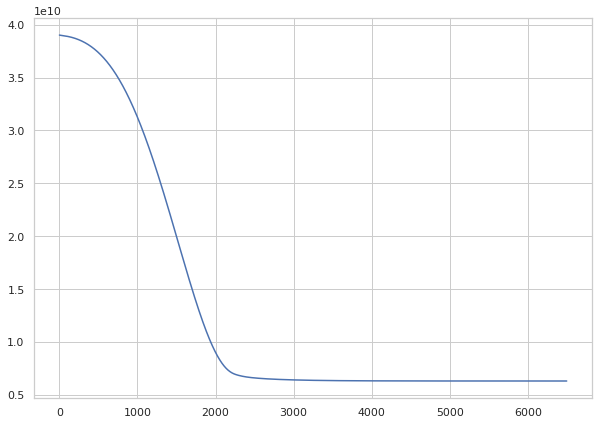

test cost: 6306961408.000
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
0.9993239080085052


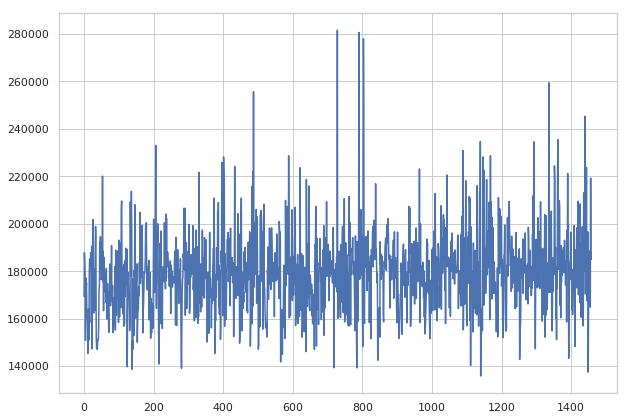

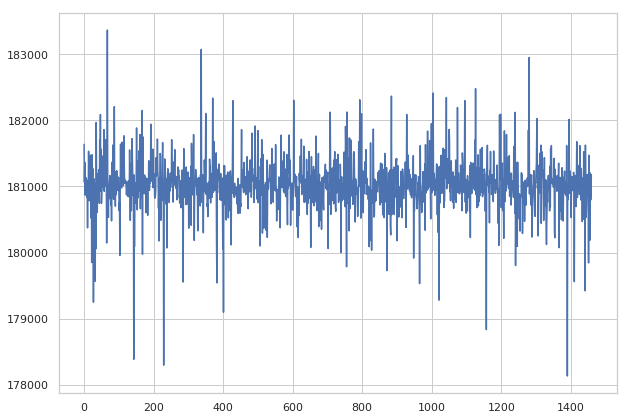

In [71]:
# train neural network with y_train
# get predictions, define loss and optimizer
prediction = neural_net_model(x_train, input_dim)
cost = tf.reduce_mean(tf.square(prediction - y_train))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

batch_size = 100
epochs = 500
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    # Training cycle
    for epoch in range(epochs):
        total_batch = int(x_train.shape[0]/batch_size)
        for i in range(total_batch-1):
            batch_x = x_train[i*batch_size:(i+1)*batch_size]
            batch_y = y_train[i*batch_size:(i+1)*batch_size]
            
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})               
            loss_history.append(c)
            
    plt.plot(range(len(loss_history)), loss_history)
    plt.show()  
    
    # running test set
    results = sess.run(prediction, feed_dict={x: x_test})
    test_cost = sess.run(cost, feed_dict={x: x_test, y: y_test})
    print('test cost: {:.3f}'.format(test_cost))
    
    # calculate r^2
    total_error = tf.reduce_sum(tf.square(y_test - tf.reduce_mean(y_test)))
    unexplained_error = tf.reduce_sum(tf.square(y_test - results))
    R_squared = 1.0 - tf.div(total_error, unexplained_error)
    print(R_squared.eval()) 
    
    plt.plot(range(y_test.shape[0]), y_test, label="Original Data")
    plt.show(); 
    plt.plot(range(results.shape[0]), results, label="Predicted Data")
    plt.show();     

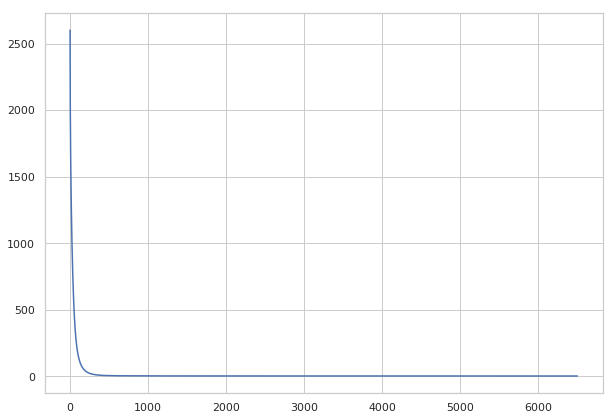

8829466000.0
0.9999911593914482


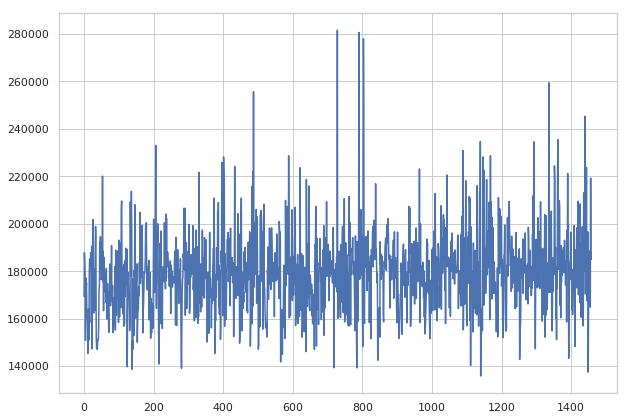

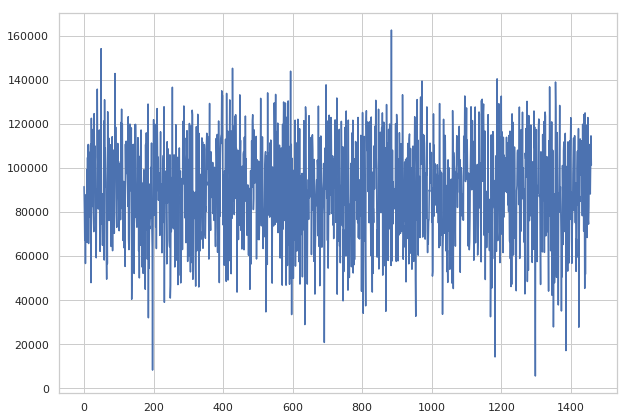

In [72]:
# train neural network with y_train_log
# get predictions, define loss and optimizer
prediction = neural_net_model(x_train, input_dim)
cost = tf.reduce_mean(tf.square(prediction - y_train_log))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

batch_size = 100
epochs = 500
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    # Training cycle
    for epoch in range(epochs):
        total_batch = int(x_train.shape[0]/batch_size)
        for i in range(total_batch-1):
            batch_x = x_train[i*batch_size:(i+1)*batch_size]
            batch_y = y_train_log[i*batch_size:(i+1)*batch_size]
            
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})               
            loss_history.append(c)

    plt.plot(range(len(loss_history)), loss_history)
    plt.show()  
    
    # running test set
    results = sess.run(prediction, feed_dict={x: x_test})
    test_cost = tf.reduce_mean(tf.square(tf.math.exp(results) - y_test))
    print(test_cost.eval())
    
    total_error = tf.reduce_sum(tf.square(y_test_log - tf.reduce_mean(y_test_log)))
    unexplained_error = tf.reduce_sum(tf.square(y_test_log - results))
    R_squared = 1.0 - tf.div(total_error, unexplained_error)
    print(R_squared.eval())
    
    plt.plot(range(y_test.shape[0]), y_test, label="Original Data")
    plt.show(); 
    plt.plot(range(results.shape[0]), np.exp(results), label="Predicted Data")
    plt.show();  